# BlockRun DQN Tutorial
This notebook demonstrates how to train a Deep Q-Network (DQN) agent to play BlockRun.
It also shows how to visualise training progress and play the game manually.

## How DQN works
1. **Environment** provides observations of the game state.
2. **Q-network** estimates action values for each possible move.
3. **Target network** stabilises training by updating more slowly.
4. **Experience** is gathered by acting "epsilon-greedily" (mostly best action, sometimes random).
5. **Loss** is the difference between predicted Q-values and target values using the Bellman equation.
6. The network is updated with gradient descent.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from blockrun import BlockRun, map_view_to_image, play_game

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


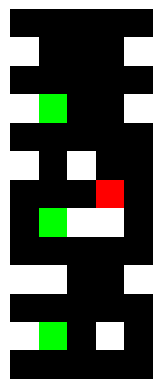

In [2]:
# Display an example view from the environment
example_env = BlockRun(50, device=device)
view = example_env.render()
plt.imshow(map_view_to_image(view))
plt.axis('off')
plt.show()

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, (5, 3), stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 64, (5, 3), stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, (5, 3), stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 128, (13, 5), padding='valid'),
            nn.ReLU(),
            nn.Conv2d(128, 4, (1, 1)),
        )

    def forward(self, x):
        return self.network(x).mean(dim=(2, 3))

In [4]:
def train_dqn(q_network=None, num_iterations=2000, epsilon=0.1, gamma=0.99):
    if q_network is None:
        q_network = QNetwork().to(device)
    target_network = QNetwork().to(device)
    target_network.load_state_dict(q_network.state_dict())
    optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    env = BlockRun(2_000_000, device=device)
    rewards = []
    for i in range(num_iterations):
        view = env.render().float().unsqueeze(0).to(device)
        q_values = q_network(view)
        if torch.rand(1) < epsilon:
            action = torch.randint(0, 4, (1,))
        else:
            action = torch.argmax(q_values)
        env.step(action.item())
        next_view = env.render().float().unsqueeze(0).to(device)
        next_q = target_network(next_view)
        target = q_values.clone()
        target[0, action] = env.current_reward + gamma * torch.max(next_q)
        loss = loss_fn(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rewards.append(env.current_reward)
        if i % 1000 == 0 and i > 0:
            target_network.load_state_dict(q_network.state_dict())
    return q_network, rewards
q_net = None

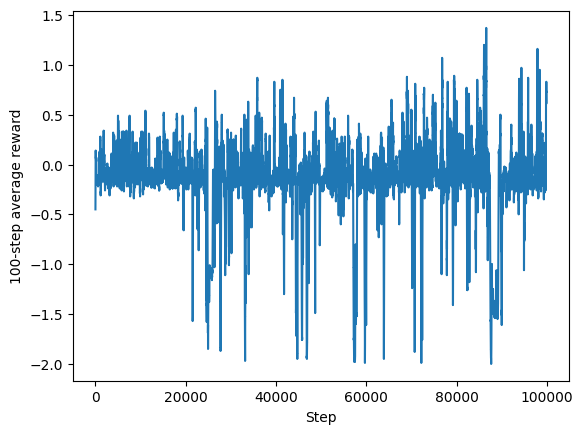

In [8]:
q_net, rewards = train_dqn(q_network=q_net, num_iterations=10_000)
avg_rewards = np.convolve(rewards, np.ones(100)/100, mode='valid')
plt.plot(avg_rewards)
plt.xlabel('Step')
plt.ylabel('100-step average reward')
plt.show()

In [11]:
def run_agent(q_network, steps=200):
    env = BlockRun(1000, device=device)
    total_reward = 0
    for _ in range(steps):
        view = env.render().float().unsqueeze(0).to(device)
        action = torch.argmax(q_network(view)).item()
        env.step(action)
        total_reward += env.current_reward
    print('Total reward over', steps, 'steps:', total_reward)
run_agent(q_net)

Total reward over 200 steps: -396


In [ ]:
# Run this cell to play the game manually using WASD keys.
play_game()